# Time DLHub Models
This notebooks demonstrates running models via DLHub, and charactizes their execution time as a function of molecular size

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 
from dlhub_sdk.client import DLHubClient
from time import perf_counter
from scipy.stats import sem
from tqdm import tqdm
from time import perf_counter
import pandas as pd
import numpy as np
import yaml
import os

In [2]:
client = DLHubClient(http_timeout=-1)

## Find Models from Our Library
We have at least a few models that are suited for the "G4MP2 Delta Learning" problem, and have labeled them all with a special DataCite subject flag.

In [3]:
models = client.search('datacite.subjects.subject:="G4MP2 Delta Learning"')
print(f'Found {len(models)} models')

Found 3 models


In [4]:
model_names = [m['dlhub']['shorthand_name'] for m in models]
model_names

['loganw_globusid/g4mp2_delta_schnet_b3lyp',
 'loganw_globusid/g4mp2_delta_schnet_wb97xd',
 'loganw_globusid/g4mp2_delta_fchl_b3lyp']

## Get Example Molecules
Get some molecules with different numbers of atoms

In [5]:
data = pd.concat([
    pd.read_json(os.path.join('..', 'data', 'output', 'g4mp2_data.json.gz'), lines=True),
    pd.read_json(os.path.join('..', 'data', 'output', 'sugar_data.json'), lines=True)
], sort=False)

Get one molecule per molecule size

In [6]:
data.drop_duplicates('n_atom', inplace=True)
data.sort_values('n_atom', inplace=True)

## Illustrate a Model
Show the metadata for one of the models and how to invoke it on a series of molecules.

In [7]:
print(yaml.dump(client.describe_servable(model_names[0]), indent=2))

datacite:
  alternateIdentifiers: []
  creators:
  - affiliations:
    - Argonne National Laboratory
    familyName: Ward
    givenName: Logan
  - affiliations:
    - Argonne National Laboratory
    familyName: Blaiszik
    givenName: Ben
  - affiliations:
    - Argonne National Laboratory
    familyName: Foster
    givenName: Ian
  - affiliations:
    - Argonne National Laboratory
    familyName: Assary
    givenName: Rajeev
  - affiliations:
    - University of Louisville
    - Argonne National Laboratory
    familyName: Narayanan
    givenName: Badri
  - affiliations:
    - Argonne National Laboratory
    familyName: Curtiss
    givenName: Larry
  descriptions: []
  fundingReferences: []
  identifier:
    identifier: 10.YET/UNASSIGNED
    identifierType: DOI
  publicationYear: '2020'
  publisher: DLHub
  relatedIdentifiers:
  - relatedIdentifier: 10.1021/acs.jctc.8b00908
    relatedIdentifierType: DOI
    relationType: Requires
  - relatedIdentifier: 10.1557/mrc.2019.107
    related

In [8]:
client.run(model_names[0], (data['xyz'].tolist(), data['u0'].tolist()))

[-0.34871382666015815,
 -0.44001897656249733,
 -0.6251134133300749,
 -0.7658303339843666,
 -1.0689759374999834,
 -1.061002045898431,
 -1.2115647001952938,
 -1.4761385556640336,
 -1.5017315292968596,
 -1.6589317568359099,
 -1.9522964765624642,
 -1.9460468281249752,
 -2.1073821874999634,
 -2.3981834306640177,
 -2.3925899101562162,
 -2.5428779062499545,
 -2.8464202382811963,
 -2.8318698085937073,
 -2.9816084882812235,
 -3.2469452832031456,
 -3.2733164550780733,
 -3.430592976562493,
 -3.74350420507811,
 -3.714305337890593,
 -3.948392132812486,
 -4.532727097656235,
 -4.154866974609362,
 -4.6333515214844425]

## Invoke Model for Each Different Molecule Sizes
We are going to run each molecule individually to get timing as a function of size

In [9]:
results = []
for m in model_names:
    for rid, mol in tqdm(data.iterrows(), desc=m):
        # Run the simulation many times to evaluate the timing
        timings = []
        for i in range(1):
            # Submit the task, measure total time
            start_time = perf_counter()
            client.run(m, ([mol['xyz']]*1, [mol['u0']]*1))
            run_time = perf_counter() - start_time

            # Get the invocation time on DLHub
            timings.append(run_time)
        results.append({
            'model': m,
            'n_atoms': mol['n_atom'],
            'timing': np.mean(timings)
        })

loganw_globusid/g4mp2_delta_schnet_b3lyp: 28it [02:30,  5.36s/it]
loganw_globusid/g4mp2_delta_schnet_wb97xd: 28it [02:30,  5.37s/it]
loganw_globusid/g4mp2_delta_fchl_b3lyp: 28it [27:31, 58.98s/it]


In [10]:
results = pd.DataFrame(results)

## Plot the Roundtrip Times
Plot the run time as a function of molecule size

In [11]:
results['model_type'] = results['model'].apply(lambda x: x.split("_")[-2])
results['input_fidelity'] = results['model'].apply(lambda x: x.split("_")[-2])

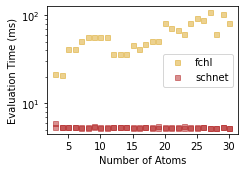

In [12]:
fig, ax = plt.subplots()

labels = {}
for gid, group in results.groupby('model'):
    mt = group['model_type'].iloc[0]
    f = group['input_fidelity'].iloc[0]
    color = 'goldenrod' if mt == 'fchl' else 'firebrick'
    marker = 'o' if f == 'b3lyp' else 's'
    l = ax.semilogy(group['n_atoms'], group['timing'],# yerr=data['timing_err'], 
                    color=color, linestyle='none', marker=marker,
                    label=mt, markersize=5, alpha=0.5)
    labels[mt] = l[0]
ax.set_xlabel('Number of Atoms')
ax.set_ylabel('Evaluation Time (ms)')
ax.legend(labels.values(), labels.keys())

fig.set_size_inches(3.5, 2.5)
fig.tight_layout()

We can expect runtimes of around 1 second for SchNet and 1 minute for FCHL models.